## Uncertainty example

\begin{align}
        p(\textbf{z}|c) &= \mathcal{C}_d(\kappa)\exp\left(\kappa\mu^T_{c}\textbf{z}\right)\\
        \mathcal{C}_d(\kappa) &= \frac{(\kappa)^{d/2-1}}{(2\pi)^{d/2}\mathcal{I}_{d/2-1}(\kappa)}
\end{align}

With d=2:

In [7]:
from scipy.special import iv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import matplotlib as mpl

# mpl.style.use('classic')


def z_Prob(z, mus, kappa, d=2, beta=0.5):
    K = mus.shape[-1]
    p_c = (1 - beta) / K
    class_probs = np.array([z_vonMises_dencity(z, mu, kappa) for mu in mus.T])
    return np.sum(class_probs * p_c) + (1 / (2 * np.pi)) * beta


def z_class_prob(class_id, z, mus, kappa, d=2, beta=0.5):
    p_z = z_Prob(z, mus, kappa, d, beta)
    K = mus.shape[1]
    if class_id == K:
        p_c = beta
        return (1 / (2 * np.pi)) * p_c / p_z
    else:
        p_c = (1 - beta) / K
        return (z_vonMises_dencity(z, mus[:, class_id], kappa) * p_c) / p_z


def z_vonMises_dencity(z, mu_c, kappa, d=2):
    C_d = kappa ** (d / 2 - 1) / ((2 * np.pi) ** (d / 2) * iv(d / 2 - 1, kappa))
    return C_d * np.exp(kappa * np.dot(z, mu_c))

In [8]:
def get_vectors_by_angle(angles):
    return np.array([[np.cos(plot_angle), np.sin(plot_angle)] for plot_angle in angles])


def compute_class_probs(class_id, zs, mus, kappa, beta):
    class_probes = []
    for z in zs:
        class_prob = z_class_prob(class_id, z, mus, kappa, beta=beta)
        class_probes.append(class_prob)
    class_probes = np.array(class_probes)
    return class_probes

In [18]:
def draw_circle(linewidth, zorder=4):
    fig, ax = plt.subplots(figsize=(5, 5))
    # plot circle
    theta = np.linspace(0, 2 * np.pi, 150)
    a = np.cos(theta)
    b = np.sin(theta)
    circle = plt.Circle((0, 0), 1, color="blue", zorder=4, alpha=0.1)
    ax.add_patch(circle)
    ax.plot(a, b, color="tab:gray", zorder=4, linewidth=linewidth)
    return fig, ax


def draw_example(kappa, gallery_class_angles, text_shift, save_name, beta=0.5):
    fontsize = 20
    linewidth = 3
    dot_size = 80

    test_color = "tab:cyan"
    # gallery_class_angles = [0.4, 0.25]
    ident_uncertain_test_point = (
        gallery_class_angles[-1] + gallery_class_angles[-2]
    ) / 2 - 0.02
    test_points_angles = [
        ident_uncertain_test_point,
        gallery_class_angles[-1]
        - (ident_uncertain_test_point - gallery_class_angles[-1]),
    ]

    gallery_class_angles = np.array(gallery_class_angles) * 2 * np.pi
    test_points_angles = np.array(test_points_angles) * 2 * np.pi
    theta = np.linspace(0, 2 * np.pi, 150)

    colors = list(mcolors.TABLEAU_COLORS)[: len(gallery_class_angles)]
    fig, ax = draw_circle(linewidth)
    # fig, ax = plt.subplots(figsize=(5, 5))
    # # plot circle
    # circle = plt.Circle((0, 0), 1, color="blue", zorder=4, alpha=0.1)
    # ax.add_patch(circle)
    # ax.plot(a, b, color="tab:gray", zorder=4, linewidth=linewidth)

    draw_dencity_angles = np.linspace(-np.pi / 3, np.pi / 3, 150)

    mus = np.stack([np.cos(gallery_class_angles), np.sin(gallery_class_angles)], axis=0)
    class_to_class_probs = []

    for i, (angle, color) in enumerate(zip(gallery_class_angles, colors)):
        mu_c = mus[:, i]
        plot_angles = angle + draw_dencity_angles
        zs = get_vectors_by_angle(plot_angles)
        class_probes = compute_class_probs(i, zs, mus, kappa, beta)
        v = zs.T * (1 + class_probes[np.newaxis, :])
        ax.plot(v[0], v[1], c=color, linewidth=linewidth)

        ax.scatter([np.cos(angle)], [np.sin(angle)], c=color, s=dot_size, zorder=5)
        ax.scatter([0], [0], color="black", s=20)

        # plot decity
        # ax.scatter(points[:, 0], points[:, 1], color=color, s=3)

    # plot_uniform_prob
    zs = get_vectors_by_angle(theta)
    class_probes = compute_class_probs(mus.shape[1], zs, mus, kappa, beta)
    v = zs.T * (1 + class_probes[np.newaxis, :])
    # ax.plot(v[0], v[1], color='black')

    # plot unc
    all_probs = []
    for i in range(mus.shape[1] + 1):
        class_probes = compute_class_probs(i, zs, mus, kappa, beta)
        all_probs.append(class_probes)
    all_probs = np.stack(all_probs, axis=0)
    unc = -np.sum(all_probs * np.log(all_probs), axis=0)
    # unc = -np.max(all_probs, axis=0) + 1
    v = zs.T * (1 + unc[np.newaxis, :])
    ax.plot(v[0], v[1], color="tab:red", linewidth=linewidth)

    # plot test points
    for test_angle in test_points_angles:
        ax.scatter(
            [np.cos(test_angle)],
            [np.sin(test_angle)],
            c=test_color,
            s=dot_size,
            zorder=5,
        )

    test_point_vectors = get_vectors_by_angle(test_points_angles)
    # entropy value

    probs_at_test_points = []
    for i in range(mus.shape[1] + 1):
        class_probes = compute_class_probs(i, test_point_vectors, mus, kappa, beta)
        probs_at_test_points.append(class_probes)
    probs_at_test_points = np.stack(probs_at_test_points, axis=0)

    unc_test = -np.sum(probs_at_test_points * np.log(probs_at_test_points), axis=0)
    unc_test = np.round(unc_test, 2)
    # unc_test = -np.max(probs_at_test_points, axis=0) + 1
    # unc_test = np.round(unc_test, 2)
    ax.annotate(
        f"${unc_test[0]}$",
        xy=test_point_vectors[0],
        xytext=[
            test_point_vectors[0][0] + text_shift[0][0],
            test_point_vectors[0][1] + text_shift[0][1],
        ],
        fontsize=fontsize,
    )
    ax.annotate(
        f"${unc_test[1]}$",
        xy=test_point_vectors[1],
        xytext=[
            test_point_vectors[1][0] + text_shift[1][0],
            test_point_vectors[1][1] + text_shift[1][1],
        ],
        fontsize=fontsize,
    )
    fig.gca().set_aspect("equal")
    ax.axis("off")
    fig.show()
    plt.savefig(save_name, dpi=300, bbox_inches="tight")

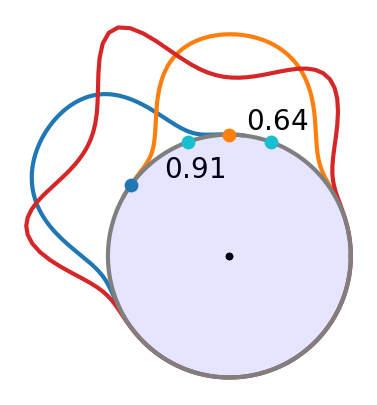

In [19]:
draw_example(
    kappa=15,
    gallery_class_angles=[0.4, 0.25],
    text_shift=[[-0.2, -0.3], [-0.2, 0.1]],
    save_name="test.png",
)

### False Identification example

In [16]:
# draw_example(kappa = 15, gallery_class_angles = [0.4, 0.25], text_shift = [[-0.2, -0.3], [-0.2, 0.1]], save_name='/app/paper_assets/images/false_ident_example.png')

### False accept/reject example

In [17]:
# draw_example(kappa = 13, gallery_class_angles = [0.48, 0.25], text_shift = [[-0.1, -0.3], [-0.35, 0.2]], save_name='/app/paper_assets/images/false_accept-reject_example.png')

## Monte Carlo sampling